# Anime or Cartoon

This blog post is actually a jupyter notebook, converted to markdown. If interested, you can find this notebook [here]().

After watching the first lesson video of the fastai course, ['Practical Deep Learning for Coders'](http://course.fast.ai/), I was moved. All those things that seemed would take years for me to achieve were now at my fingertips. 

The thing is, I am a person who likes to front-load on theory, understanding how every small component works in the ultimate big picture. But this approach is very, very frustrating. I started studying from a book called 'Pattern Recognition and Machine Learning' by Christopher M. Bishop. I enjoyed the math at first, but then it started getting on my nerves. In this case, I wanted to learn by _doing_. So, after researching a little online, I finally came across fastai. I like how they first teach _how_ the code works and _then_ they teach _why_ it works. The course is awesome. After the first lesson, I wanted to create an image classifier too, so I made one which classifies a given image into two categories: anime or cartoon.

So before starting, I tried to find out if someone else had also had this grand idea before. And sure enough, there were quite a few! Great minds think alike!

I first found a paper titled 'Are Anime Cartoons?' by 'Chai, Ramesh, Yeo'. You can read it [here](http://cs229.stanford.edu/proj2016/report/ChaiRameshYeo-AreAnimeCartoons-report.pdf). It helped me understand a little about how CNNs actually work. This talked about how CNN models outperform MLP models in the cases where a spatially aware algorithm is necessary to classify images. Good for me, because that's exactly what the first fastai lesson was about. We learnt how to train pretrained models (like resnet34 and resnet50) using the principles of transfer learning and how to further fine-tune these models to better fit our data. [This](https://www.youtube.com/watch?v=VwVg9jCtqaU) video also helped me understand CNNs.

## The Project

### Step 1: Gather Data

The fastai library has a neat feature which allows you to download pictures from a list of their links. So, I created two csv files containing only the links of the anime and cartoon images. For the anime pictures, I used [this](https://www.kaggle.com/alamson/safebooru) dataset. For the cartoon pictures, I made use of the [Fatkun Batch Download Image](https://chrome.google.com/webstore/detail/fatkun-batch-download-ima/nnjjahlikiabnchcpehcpkdeckfgnohf) chrome browser extension to extract about 250 image links.

I feel that both the datasets could have been better curated for this project.

Moving on, I uploaded the csv files to my google cloud platform server and with the help of the fastai library downloaded the images into two separate folders.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate

In [3]:
bs = 64

In [4]:
path = Path('/home/jupyter/tutorials/data/anime-vs-cartoon')

In [5]:
classes = ['anime','cartoon']
for c in classes:
    print(c)
    folder = c
    file = 'urls_%s.csv' % c
    dest = path/folder
    dest.mkdir(parents=True, exist_ok=True)
    download_images(path/file, dest, max_pics=1000)
    verify_images(path/c, delete=True, max_size=500)

anime


cannot identify image file <_io.BufferedReader name='/home/jupyter/tutorials/data/anime-vs-cartoon/anime/00000091.jpg'>
cannot identify image file <_io.BufferedReader name='/home/jupyter/tutorials/data/anime-vs-cartoon/anime/00000670.jpg'>
cannot identify image file <_io.BufferedReader name='/home/jupyter/tutorials/data/anime-vs-cartoon/anime/00000856.png'>
cannot identify image file <_io.BufferedReader name='/home/jupyter/tutorials/data/anime-vs-cartoon/anime/00000806.jpg'>
cannot identify image file <_io.BufferedReader name='/home/jupyter/tutorials/data/anime-vs-cartoon/anime/00000901.png'>
cannot identify image file <_io.BufferedReader name='/home/jupyter/tutorials/data/anime-vs-cartoon/anime/00000098.jpg'>
cannot identify image file <_io.BufferedReader name='/home/jupyter/tutorials/data/anime-vs-cartoon/anime/00000659.jpg'>
cannot identify image file <_io.BufferedReader name='/home/jupyter/tutorials/data/anime-vs-cartoon/anime/00000150.jpg'>
cannot identify image file <_io.Buffered

For some reason a lot of anime image URLs were broken. Good thing we verified the images.

### Step 2: Transform & View Data

Before training our model, we must normalise our images. The fastai library provides a really cool class called 'ImageDataBunch' which allows us to do operations on our image datasets in bulk. You can find out more about this class in the fastai docs [here](https://docs.fast.ai/vision.data.html).

In [6]:
np.random.seed(2)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2, ds_tfms=get_transforms(),
                                  size=224, num_workers=4).normalize(imagenet_stats)

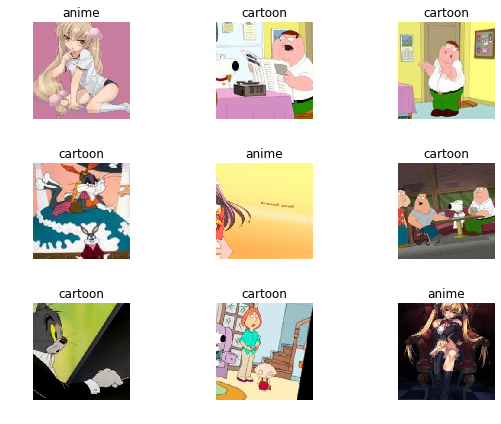

In [7]:
data.show_batch(rows = 3, figsize=(8,6))

In [9]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['anime', 'cartoon'], 2, 421, 105)

### Step 3: Train Model

We can finally start training our model. For this project I decided to go with the ResNet34 model.

In [10]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [11]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.735565,0.621040,0.380952,00:07
1,0.421396,0.046641,0.009524,00:03
2,0.296799,0.016185,0.009524,00:03
3,0.222645,0.011620,0.009524,00:03


In [12]:
learn.save('stage-1')

### Step 4: Interpretation

In [13]:
interp = ClassificationInterpretation.from_learner(learn)

losses, idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

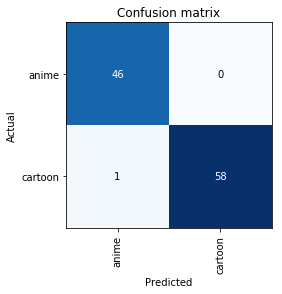

In [14]:
interp.plot_confusion_matrix()

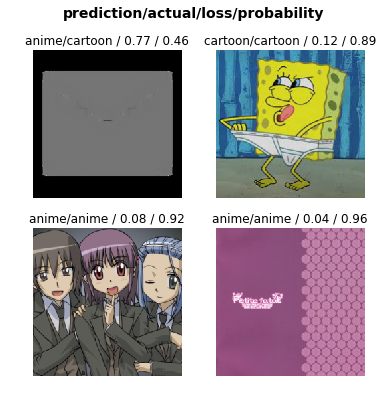

In [15]:
interp.plot_top_losses(4, figsize=(6, 6), heatmap=False)

Looking at the above pictures, it makes sense why our model classified these incorrectly! Even a casual anime viewer would be confused when looking at these pictures. Once again, please excuse me for my poorly curated data sets.

### Step 5: Fine Tuning

Let's see if we can reduce the error rate by choosing a range of learning rate optimum for this model.

epoch,train_loss,valid_loss,error_rate,time
0,0.102109,0.044281,0.019048,00:04


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


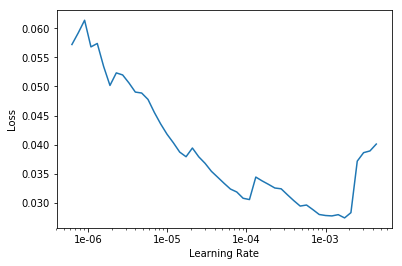

In [17]:
learn.unfreeze()
learn.fit_one_cycle(1)
learn.lr_find()
learn.recorder.plot()

In [18]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.040849,0.050569,0.019048,00:04
1,0.036746,0.045013,0.019048,00:04


The train_loss variable has gone down considerably. This probably means that the model is overfitting the training data. Let's just revert back to the old model (before the fine tuning).

In [19]:
learn.load('stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (421 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
cartoon,cartoon,cartoon,cartoon,cartoon
Path: /home/jupyter/tutorials/data/anime-vs-cartoon;

Valid: LabelList (105 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
anime,anime,anime,cartoon,cartoon
Path: /home/jupyter/tutorials/data/anime-vs-cartoon;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  

### Step 6: Testing

This step was a lot of fun! I tested the model on a lot of images from my favourite anime and cartoons, and the thing that surprised me the most was, the model was _actually_ working! I was a little sceptical at first, but after testing it a couple of times I was pretty satisfied with it's performance. It seemed to guess the image correctly most of the time, save for a few instances. For example, it incorrectly identified a scene from [Boku no Hero Academia](https://myanimelist.net/manga/75989/Boku_no_Hero_Academia) as a cartoon.

In [20]:
learn.export()

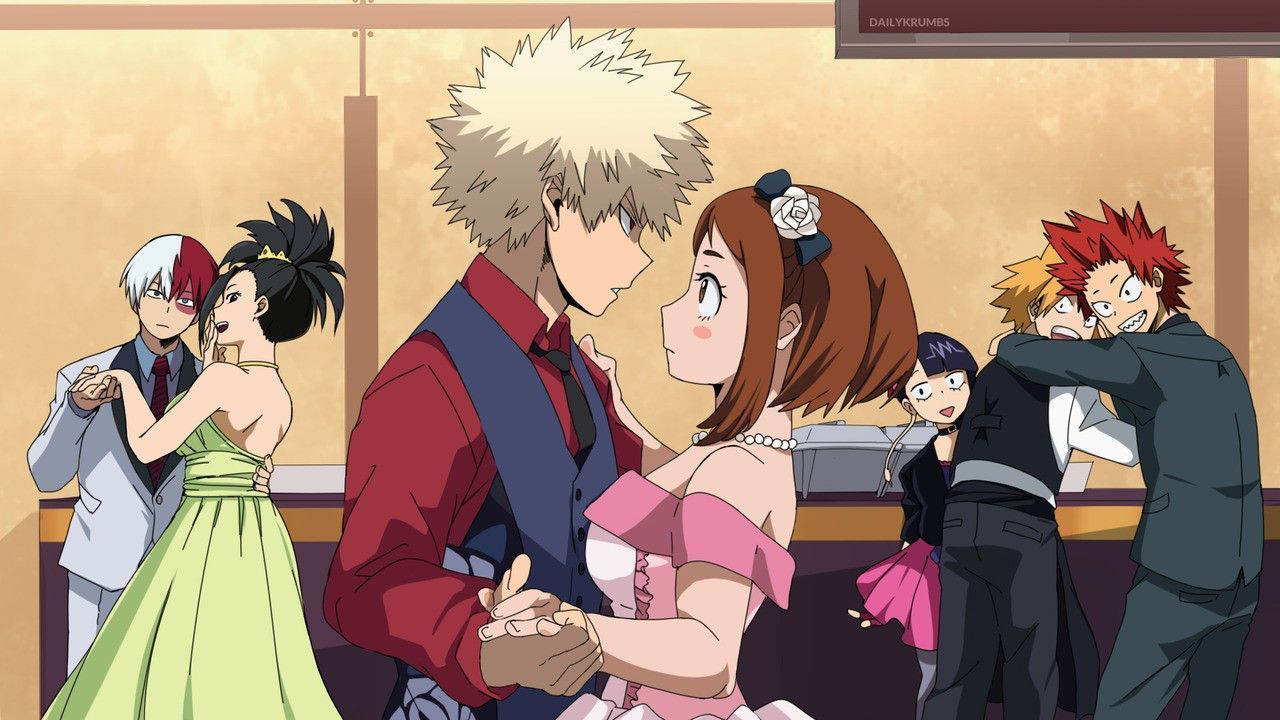

In [29]:
img = open_image(Path('/home/jupyter/tutorials/data/test/bnha3.jpg'))
img

In [30]:
learn = load_learner(path)
learn.predict(img)

(Category cartoon, tensor(1), tensor([0.1647, 0.8353]))

As you can see, the model isn't perfect! Also, there are many things that I do not understand very well yet, like
* the behaviour of the error_rate variable above (why does it become constant?)
* how do I properly interpret the loss vs learning rate plot?
* how can I ensure that my data set is good enough? (exploring concepts like normalisation)
* and some more

I will try to find the answers to these questions as I progress further in the course, discuss in the forums etc.. I will post whatever I learn here on this blog.

### Step 7: Put Model in Production

This was something I made just for fun, as a project to test out what I had learnt. I have no plans to put this in production anytime soon, for this is in no means perfect and is only a trivial application of deep learning. However, I may eventually create a very basic android app just to see how I can integrate deep learning with an app running on a mobile device.

## Future Projects

I have only just begun learning deep learning, but I am already having a lot of fun. You can expect the blog posts to get more frequent, because I have decided to document each step of my journey here. If you have any comments or questions, feel free to drop an email to me!